# 1. 导论

在前面的学习中，我们探讨了一系列简单而实用的回归和分类模型，同时也探讨了如何使用集成学习家族中的Bagging思想去优化最终的模型。Bagging思想的实质是：通过Bootstrap 的方式对全样本数据集进行抽样得到抽样子集，对不同的子集使用同一种基本模型进行拟合，然后投票得出最终的预测。我们也从前面的探讨知道：Bagging主要通过降低方差的方式减少预测误差。那么，本章介绍的Boosting是与Bagging截然不同的思想，Boosting方法是使用同一组数据集进行反复学习，得到一系列简单模型，然后组合这些模型构成一个预测性能十分强大的机器学习模型。显然，Boosting思想提高最终的预测效果是通过不断减少偏差的形式，与Bagging有着本质的不同。在Boosting这一大类方法中，笔者主要介绍两类常用的Boosting方式：Adaptive Boosting 和 Gradient Boosting 以及它们的变体Xgboost、LightGBM以及Catboost。

# 2. Boosting方法的基本思路

在正式介绍Boosting思想之前，我想先介绍两个例子：                   
第一个例子：不知道大家有没有做过错题本，我们将每次测验的错的题目记录在错题本上，不停的翻阅，直到我们完全掌握(也就是能够在考试中能够举一反三)。              
第二个例子：对于一个复杂任务来说，将多个专家的判断进行适当的综合所作出的判断，要比其中任何一个专家单独判断要好。实际上这是一种“三个臭皮匠顶个诸葛亮的道理”。                 
这两个例子都说明Boosting的道理，也就是不错地重复学习达到最终的要求。                
Boosting的提出与发展离不开Valiant和 Kearns的努力，历史上正是Valiant和 Kearns提出了"强可学习"和"弱可学习"的概念。那什么是"强可学习"和"弱可学习"呢？在概率近似正确PAC学习的框架下：            
  - 弱学习：识别错误率小于1/2（即准确率仅比随机猜测略高的学习算法）                     
  - 强学习：识别准确率很高并能在多项式时间内完成的学习算法                                   

非常有趣的是，在PAC 学习的框架下，强可学习和弱可学习是等价的，也就是说一个概念是强可学习的充分必要条件是这个概念是弱可学习的。这样一来，问题便是：在学习中，如果已经发现了弱可学习算法，能否将他提升至强可学习算法。因为，弱可学习算法比强可学习算法容易得多。提升方法就是从弱学习算法出发，反复学习，得到一系列弱分类器(又称为基本分类器)，然后通过一定的形式去组合这些弱分类器构成一个强分类器。大多数的Boosting方法都是通过改变训练数据集的概率分布(训练数据不同样本的权值)，针对不同概率分布的数据调用弱分类算法学习一系列的弱分类器。              
对于Boosting方法来说，有两个问题需要给出答案：第一个是每一轮学习应该如何改变数据的概率分布，第二个是如何将各个弱分类器组合起来。关于这两个问题，不同的Boosting算法会有不同的答案，我们接下来介绍一种最经典的Boosting算法----Adaboost，我们需要理解Adaboost是怎么处理这两个问题以及为什么这么处理的。

# 3. Adaboost算法

**Adaboost的基本原理**                             

对于Adaboost来说，解决上述的两个问题的方式是：1. 提高那些被前一轮分类器错误分类的样本的权重，而降低那些被正确分类的样本的权重。这样一来，那些在上一轮分类器中没有得到正确分类的样本，由于其权重的增大而在后一轮的训练中“备受关注”。2. 各个弱分类器的组合是通过采取加权多数表决的方式，具体来说，加大分类错误率低的弱分类器的权重，因为这些分类器能更好地完成分类任务，而减小分类错误率较大的弱分类器的权重，使其在表决中起较小的作用。                          
现在，我们来具体介绍Adaboost算法：(参考李航老师的《统计学习方法》)                       
假设给定一个二分类的训练数据集：$T=\left\{\left(x_{1}, y_{1}\right),\left(x_{2}, y_{2}\right), \cdots,\left(x_{N}, y_{N}\right)\right\}$，其中每个样本点由特征与类别组成。特征$x_{i} \in \mathcal{X} \subseteq \mathbf{R}^{n}$，类别$y_{i} \in \mathcal{Y}=\{-1,+1\}$，$\mathcal{X}$是特征空间，$ \mathcal{Y}$是类别集合，输出最终分类器$G(x)$。Adaboost算法如下：                 
(1) 初始化训练数据的分布：$D_{1}=\left(w_{11}, \cdots, w_{1 i}, \cdots, w_{1 N}\right), \quad w_{1 i}=\frac{1}{N}, \quad i=1,2, \cdots, N$                       
(2) 对于m=1,2,...,M            
   - 使用具有权值分布$D_m$的训练数据集进行学习，得到基本分类器：$G_{m}(x): \mathcal{X} \rightarrow\{-1,+1\}$                  
   - 计算$G_m(x)$在训练集上的分类误差率$e_{m}=\sum_{i=1}^{N} P\left(G_{m}\left(x_{i}\right) \neq y_{i}\right)=\sum_{i=1}^{N} w_{m i} I\left(G_{m}\left(x_{i}\right) \neq y_{i}\right)$                   
   - 计算$G_m(x)$的系数$\alpha_{m}=\frac{1}{2} \log \frac{1-e_{m}}{e_{m}}$，这里的log是自然对数ln                         
   - 更新训练数据集的权重分布                
   $$
   \begin{array}{c}
   D_{m+1}=\left(w_{m+1,1}, \cdots, w_{m+1, i}, \cdots, w_{m+1, N}\right) \\
   w_{m+1, i}=\frac{w_{m i}}{Z_{m}} \exp \left(-\alpha_{m} y_{i} G_{m}\left(x_{i}\right)\right), \quad i=1,2, \cdots, N
   \end{array}
   $$                       
   这里的$Z_m$是规范化因子，使得$D_{m+1}$称为概率分布，$Z_{m}=\sum_{i=1}^{N} w_{m i} \exp \left(-\alpha_{m} y_{i} G_{m}\left(x_{i}\right)\right)$                          

(3) 构建基本分类器的线性组合$f(x)=\sum_{m=1}^{M} \alpha_{m} G_{m}(x)$，得到最终的分类器                       

$$
\begin{aligned}
G(x) &=\operatorname{sign}(f(x)) \\
&=\operatorname{sign}\left(\sum_{m=1}^{M} \alpha_{m} G_{m}(x)\right)
\end{aligned}
$$                          

下面对Adaboost算法做如下说明：                                            
对于步骤(1)，假设训练数据的权值分布是均匀分布，是为了使得第一次没有先验信息的条件下每个样本在基本分类器的学习中作用一样。                         
对于步骤(2)，每一次迭代产生的基本分类器$G_m(x)$在加权训练数据集上的分类错误率$\begin{aligned}e_{m} &=\sum_{i=1}^{N} P\left(G_{m}\left(x_{i}\right) \neq y_{i}\right) =\sum_{G_{m}\left(x_{i}\right) \neq y_{i}} w_{m i}\end{aligned}$代表了在$G_m(x)$中分类错误的样本权重和，这点直接说明了权重分布$D_m$与$G_m(x)$的分类错误率$e_m$有直接关系。同时，在步骤(2)中，计算基本分类器$G_m(x)$的系数$\alpha_m$，$\alpha_{m}=\frac{1}{2} \log \frac{1-e_{m}}{e_{m}}$，它表示了$G_m(x)$在最终分类器的重要性程度，$\alpha_m$的取值由基本分类器$G_m(x)$的分类错误率有直接关系，当$e_{m} \leqslant \frac{1}{2}$时，$\alpha_{m} \geqslant 0$，并且$\alpha_m$随着$e_m$的减少而增大，因此分类错误率越小的基本分类器在最终分类器的作用越大！                       
**最重要的，对于步骤(2)中的样本权重的更新：  **                                    
$$
w_{m+1, i}=\left\{\begin{array}{ll}
\frac{w_{m i}}{Z_{m}} \mathrm{e}^{-\alpha_{m}}, & G_{m}\left(x_{i}\right)=y_{i} \\
\frac{w_{m i}}{Z_{m}} \mathrm{e}^{\alpha_{m}}, & G_{m}\left(x_{i}\right) \neq y_{i}
\end{array}\right.
$$                        
因此，从上式可以看到：被基本分类器$G_m(x)$错误分类的样本的权重扩大，被正确分类的样本权重减少，二者相比相差$\mathrm{e}^{2 \alpha_{m}}=\frac{1-e_{m}}{e_{m}}$倍。                             
对于步骤(3)，线性组合$f(x)$实现了将M个基本分类器的加权表决，系数$\alpha_m$标志了基本分类器$G_m(x)$的重要性，值得注意的是：所有的$\alpha_m$之和不为1。$f(x)$的符号决定了样本x属于哪一类。             

下面，我们使用一组简单的数据来手动计算Adaboost算法的过程：(例子来源：http://www.csie.edu.tw)                                                               

训练数据如下表，假设基本分类器的形式是一个分割$x<v$或$x>v$表示，阈值v由该基本分类器在训练数据集上分类错误率$e_m$最低确定。                                                
$$
\begin{array}{ccccccccccc}
\hline \text { 序号 } & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\
\hline x & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \\
y & 1 & 1 & 1 & -1 & -1 & -1 & 1 & 1 & 1 & -1 \\
\hline
\end{array}
$$                                          
解：                        
初始化样本权值分布
$$
\begin{aligned}
D_{1} &=\left(w_{11}, w_{12}, \cdots, w_{110}\right) \\
w_{1 i} &=0.1, \quad i=1,2, \cdots, 10
\end{aligned}
$$                                  
对m=1:                      
   - 在权值分布$D_1$的训练数据集上，遍历每个结点并计算分类误差率$e_m$，阈值取v=2.5时分类误差率最低，那么基本分类器为：
   $$
   G_{1}(x)=\left\{\begin{array}{ll}
   1, & x<2.5 \\
   -1, & x>2.5
   \end{array}\right.
   $$                         
   - $G_1(x)$在训练数据集上的误差率为$e_{1}=P\left(G_{1}\left(x_{i}\right) \neq y_{i}\right)=0.3$。                                           
   - 计算$G_1(x)$的系数：$\alpha_{1}=\frac{1}{2} \log \frac{1-e_{1}}{e_{1}}=0.4236$               
   - 更新训练数据的权值分布：                  
   $$
   \begin{aligned}
   D_{2}=&\left(w_{21}, \cdots, w_{2 i}, \cdots, w_{210}\right) \\
   w_{2 i}=& \frac{w_{1 i}}{Z_{1}} \exp \left(-\alpha_{1} y_{i} G_{1}\left(x_{i}\right)\right), \quad i=1,2, \cdots, 10 \\
   D_{2}=&(0.07143,0.07143,0.07143,0.07143,0.07143,0.07143,\\
   &0.16667,0.16667,0.16667,0.07143) \\
   f_{1}(x) &=0.4236 G_{1}(x)
   \end{aligned}
   $$

对于m=2：                   
   - 在权值分布$D_2$的训练数据集上，遍历每个结点并计算分类误差率$e_m$，阈值取v=8.5时分类误差率最低，那么基本分类器为：                  
   $$
   G_{2}(x)=\left\{\begin{array}{ll}
   1, & x<8.5 \\
   -1, & x>8.5
   \end{array}\right.
   $$                       
   - $G_2(x)$在训练数据集上的误差率为$e_2 = 0.2143$                    
   - 计算$G_2(x)$的系数：$\alpha_2 = 0.6496$                        
   - 更新训练数据的权值分布：                  
   $$
   \begin{aligned}
   D_{3}=&(0.0455,0.0455,0.0455,0.1667,0.1667,0.1667\\
   &0.1060,0.1060,0.1060,0.0455) \\
   f_{2}(x) &=0.4236 G_{1}(x)+0.6496 G_{2}(x)
   \end{aligned}
   $$                   
   
对m=3：                          
   - 在权值分布$D_3$的训练数据集上，遍历每个结点并计算分类误差率$e_m$，阈值取v=5.5时分类误差率最低，那么基本分类器为：                     
   $$
   G_{3}(x)=\left\{\begin{array}{ll}
   1, & x>5.5 \\
   -1, & x<5.5
   \end{array}\right.
   $$                               
   - $G_3(x)$在训练数据集上的误差率为$e_3 = 0.1820$                       
   - 计算$G_3(x)$的系数：$\alpha_3 = 0.7514$                                 
   - 更新训练数据的权值分布：                    
   $$
   D_{4}=(0.125,0.125,0.125,0.102,0.102,0.102,0.065,0.065,0.065,0.125)
   $$                       
   
于是得到：$f_{3}(x)=0.4236 G_{1}(x)+0.6496 G_{2}(x)+0.7514 G_{3}(x)$，分类器$\operatorname{sign}\left[f_{3}(x)\right]$在训练数据集上的误分类点的个数为0。                                
于是得到最终分类器为：$G(x)=\operatorname{sign}\left[f_{3}(x)\right]=\operatorname{sign}\left[0.4236 G_{1}(x)+0.6496 G_{2}(x)+0.7514 G_{3}(x)\right]$

**下面，我们使用sklearn对Adaboost算法进行建模：**

本次案例我们使用一份UCI的机器学习库里的开源数据集：葡萄酒数据集，该数据集可以在 ( https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data )上获得。该数据集包含了178个样本和13个特征，从不同的角度对不同的化学特性进行描述，我们的任务是根据这些数据预测红酒属于哪一个类别。(案例来源《python机器学习(第二版》)

In [1]:
# 引入数据科学相关工具包：
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

In [3]:
# 加载训练数据：         
wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data",header=None)
wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols','Flavanoids', 'Nonflavanoid phenols', 
                'Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']

In [4]:
# 数据查看：
print("Class labels",np.unique(wine["Class label"]))
wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


下面对数据做简单解读：                    
   - Class label：分类标签         
   - Alcohol：酒精                   
   - Malic acid：苹果酸                      
   - Ash：灰                  
   - Alcalinity of ash：灰的碱度                  
   - Magnesium：镁                     
   - Total phenols：总酚                      
   - Flavanoids：黄酮类化合物                      
   - Nonflavanoid phenols：非黄烷类酚类                      
   - Proanthocyanins：原花青素                     
   - Color intensity：色彩强度                 
   - Hue：色调                       
   - OD280/OD315 of diluted wines：稀释酒OD280 OD350                      
   - Proline：脯氨酸                 

In [5]:
# 数据预处理
# 仅仅考虑2，3类葡萄酒，去除1类
wine = wine[wine['Class label'] != 1]
y = wine['Class label'].values
X = wine[['Alcohol','OD280/OD315 of diluted wines']].values

# 将分类标签变成二进制编码：
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# 按8：2分割训练集和测试集
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)  # stratify参数代表了按照y的类别等比例抽样

In [6]:
# 使用单一决策树建模
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=1)
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train,tree_test))

Decision tree train/test accuracies 0.916/0.875


In [7]:
# 使用sklearn实现Adaboost(基分类器为决策树)
'''
AdaBoostClassifier相关参数：
base_estimator：基本分类器，默认为DecisionTreeClassifier(max_depth=1)
n_estimators：终止迭代的次数
learning_rate：学习率
algorithm：训练的相关算法，{'SAMME'，'SAMME.R'}，默认='SAMME.R'
random_state：随机种子
'''
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)
ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print('Adaboost train/test accuracies %.3f/%.3f' % (ada_train,ada_test))

Adaboost train/test accuracies 1.000/0.917


结果分析：单层决策树似乎对训练数据欠拟合，而Adaboost模型正确地预测了训练数据的所有分类标签，而且与单层决策树相比，Adaboost的测试性能也略有提高。然而，为什么模型在训练集和测试集的性能相差这么大呢？我们使用图像来简单说明下这个道理！

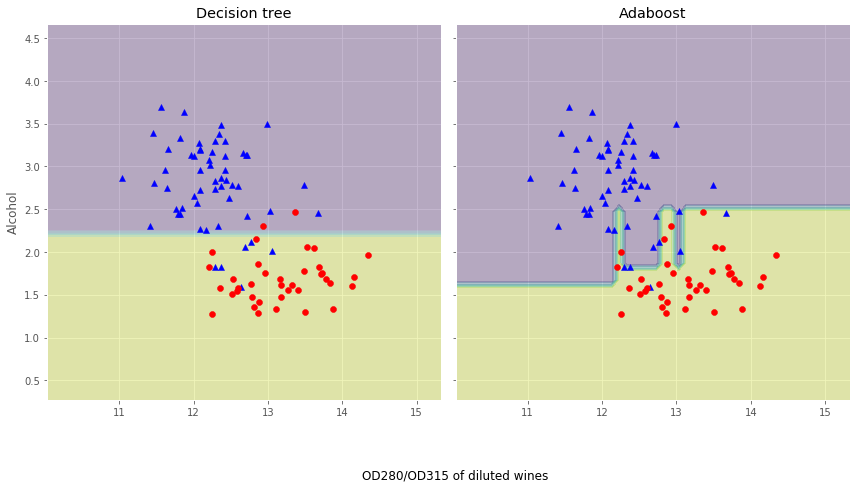

In [8]:
# 画出单层决策树与Adaboost的决策边界：
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,sharex='col',sharey='row',figsize=(12, 6))
for idx, clf, tt in zip([0, 1],[tree, ada],['Decision tree', 'Adaboost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],X_train[y_train==0, 1],c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],X_train[y_train==1, 1],c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2,s='OD280/OD315 of diluted wines',ha='center',va='center',fontsize=12,transform=axarr[1].transAxes)
plt.show()

从上面的决策边界图可以看到：Adaboost模型的决策边界比单层决策树的决策边界要复杂的多。也就是说，Adaboost试图用增加模型复杂度而降低偏差的方式去减少总误差，但是过程中引入了方差，可能出现国拟合，因此在训练集和测试集之间的性能存在较大的差距，这就简单地回答的刚刚问题。值的注意的是：与单个分类器相比，Adaboost等Boosting模型增加了计算的复杂度，在实践中需要仔细思考是否愿意为预测性能的相对改善而增加计算成本，而且Boosting方式无法做到现在流行的并行计算的方式进行训练，因为每一步迭代都要基于上一部的基本分类器。

# 4. 前向分步算法

回看Adaboost的算法内容，我们需要通过计算M个基本分类器，每个分类器的错误率、样本权重以及模型权重。我们可以认为：Adaboost每次学习单一分类器以及单一分类器的参数(权重)。接下来，我们抽象出Adaboost算法的整体框架逻辑，构建集成学习的一个非常重要的框架----前向分步算法，有了这个框架，我们不仅可以解决分类问题，也可以解决回归问题。                               
**(1) 加法模型：**                                 
在Adaboost模型中，我们把每个基本分类器合成一个复杂分类器的方法是每个基本分类器的加权和，即：$f(x)=\sum_{m=1}^{M} \beta_{m} b\left(x ; \gamma_{m}\right)$，其中，$b\left(x ; \gamma_{m}\right)$为即基本分类器，$\gamma_{m}$为基本分类器的参数，$\beta_m$为基本分类器的权重，显然这与第二章所学的加法模型。为什么这么说呢？大家把$b(x ; \gamma_{m})$看成是即函数即可。                       
在给定训练数据以及损失函数$L(y, f(x))$的条件下，学习加法模型$f(x)$就是：                        
$$
\min _{\beta_{m}, \gamma_{m}} \sum_{i=1}^{N} L\left(y_{i}, \sum_{m=1}^{M} \beta_{m} b\left(x_{i} ; \gamma_{m}\right)\right)
$$                      
通常这是一个复杂的优化问题，很难通过简单的凸优化的相关知识进行解决。前向分步算法可以用来求解这种方式的问题，它的基本思路是：因为学习的是加法模型，如果从前向后，每一步只优化一个基函数及其系数，逐步逼近目标函数，那么就可以降低优化的复杂度。具体而言，每一步只需要优化：                    
$$
\min _{\beta, \gamma} \sum_{i=1}^{N} L\left(y_{i}, \beta b\left(x_{i} ; \gamma\right)\right)
$$                                   
**(2) 前向分步算法：**                              
给定数据集$T=\left\{\left(x_{1}, y_{1}\right),\left(x_{2}, y_{2}\right), \cdots,\left(x_{N}, y_{N}\right)\right\}$，$x_{i} \in \mathcal{X} \subseteq \mathbf{R}^{n}$，$y_{i} \in \mathcal{Y}=\{+1,-1\}$。损失函数$L(y, f(x))$，基函数集合$\{b(x ; \gamma)\}$，我们需要输出加法模型$f(x)$。                         
   - 初始化：$f_{0}(x)=0$                           
   - 对m = 1,2,...,M:                     
      - (a) 极小化损失函数：
      $$
      \left(\beta_{m}, \gamma_{m}\right)=\arg \min _{\beta, \gamma} \sum_{i=1}^{N} L\left(y_{i}, f_{m-1}\left(x_{i}\right)+\beta b\left(x_{i} ; \gamma\right)\right)
      $$                        
      得到参数$\beta_{m}$与$\gamma_{m}$                                           
      - (b) 更新：                          
      $$
      f_{m}(x)=f_{m-1}(x)+\beta_{m} b\left(x ; \gamma_{m}\right)
      $$                                       
   - 得到加法模型：                           
   $$
   f(x)=f_{M}(x)=\sum_{m=1}^{M} \beta_{m} b\left(x ; \gamma_{m}\right)
   $$                                                     

这样，前向分步算法将同时求解从m=1到M的所有参数$\beta_{m}$，$\gamma_{m}$的优化问题简化为逐次求解各个$\beta_{m}$，$\gamma_{m}$的问题。                           
**(3) 前向分步算法与Adaboost的关系：**                                 
由于这里不是我们的重点，我们主要阐述这里的结论，不做相关证明，具体的证明见李航老师的《统计学习方法》第八章的3.2节。Adaboost算法是前向分步算法的特例，Adaboost算法是由基本分类器组成的加法模型，损失函数为指数损失函数。

# 5. 梯度提升决策树(GBDT)

(1) 基于残差学习的提升树算法：                                      
在前面的学习过程中，我们一直讨论的都是分类树，比如Adaboost算法，并没有涉及回归的例子。在上一小节我们提到了一个加法模型+前向分步算法的框架，那能否使用这个框架解决回归的例子呢？答案是肯定的。接下来我们来探讨下如何使用加法模型+前向分步算法的框架实现回归问题。                                 
在使用加法模型+前向分步算法的框架解决问题之前，我们需要首先确定框架内使用的基函数是什么，在这里我们使用决策树分类器。前面第二章我们已经学过了回归树的基本原理，树算法最重要是寻找最佳的划分点，分类树用纯度来判断最佳划分点使用信息增益（ID3算法），信息增益比（C4.5算法），基尼系数（CART分类树）。但是在回归树中的样本标签是连续数值，可划分点包含了所有特征的所有可取的值。所以再使用熵之类的指标不再合适，取而代之的是平方误差，它能很好的评判拟合程度。基函数确定了以后，我们需要确定每次提升的标准是什么。回想Adaboost算法，在Adaboost算法内使用了分类错误率修正样本权重以及计算每个基本分类器的权重，那回归问题没有分类错误率可言，也就没办法在这里的回归问题使用了，因此我们需要另辟蹊径。模仿分类错误率，我们用每个样本的残差表示每次使用基函数预测时没有解决的那部分问题。因此，我们可以得出如下算法：                                  
输入数据集$T=\left\{\left(x_{1}, y_{1}\right),\left(x_{2}, y_{2}\right), \cdots,\left(x_{N}, y_{N}\right)\right\}, x_{i} \in \mathcal{X} \subseteq \mathbf{R}^{n}, y_{i} \in \mathcal{Y} \subseteq \mathbf{R}$，输出最终的提升树$f_{M}(x)$                             
   - 初始化$f_0(x) = 0$                        
   - 对m = 1,2,...,M：                  
      - 计算每个样本的残差:$r_{m i}=y_{i}-f_{m-1}\left(x_{i}\right), \quad i=1,2, \cdots, N$                                    
      - 拟合残差$r_{mi}$学习一棵回归树，得到$T\left(x ; \Theta_{m}\right)$                        
      - 更新$f_{m}(x)=f_{m-1}(x)+T\left(x ; \Theta_{m}\right)$
   - 得到最终的回归问题的提升树：$f_{M}(x)=\sum_{m=1}^{M} T\left(x ; \Theta_{m}\right)$                         
   
下面我们用一个实际的案例来使用这个算法：(案例来源：李航老师《统计学习方法》)                                                             
训练数据如下表，学习这个回归问题的提升树模型，考虑只用树桩作为基函数。                                  
![jupyter](./1.png)                                             
![jupyter](./2.png)                                    
![jupyter](./3.png)                              
![jupyter](./4.png)                                  
![jupyter](./5.png)                             
至此，我们已经能够建立起依靠加法模型+前向分步算法的框架解决回归问题的算法，叫提升树算法。那么，这个算法还是否有提升的空间呢？                                       
(2) 梯度提升决策树算法(GBDT)：                                
提升树利用加法模型和前向分步算法实现学习的过程，当损失函数为平方损失和指数损失时，每一步优化是相当简单的，也就是我们前面探讨的提升树算法和Adaboost算法。但是对于一般的损失函数而言，往往每一步的优化不是那么容易，针对这一问题，我们得分析问题的本质，也就是是什么导致了在一般损失函数条件下的学习困难。对比以下损失函数：                          
$$
\begin{array}{l|l|l}
\hline \text { Setting } & \text { Loss Function } & -\partial L\left(y_{i}, f\left(x_{i}\right)\right) / \partial f\left(x_{i}\right) \\
\hline \text { Regression } & \frac{1}{2}\left[y_{i}-f\left(x_{i}\right)\right]^{2} & y_{i}-f\left(x_{i}\right) \\
\hline \text { Regression } & \left|y_{i}-f\left(x_{i}\right)\right| & \operatorname{sign}\left[y_{i}-f\left(x_{i}\right)\right] \\
\hline \text { Regression } & \text { Huber } & y_{i}-f\left(x_{i}\right) \text { for }\left|y_{i}-f\left(x_{i}\right)\right| \leq \delta_{m} \\
& & \delta_{m} \operatorname{sign}\left[y_{i}-f\left(x_{i}\right)\right] \text { for }\left|y_{i}-f\left(x_{i}\right)\right|>\delta_{m} \\
& & \text { where } \delta_{m}=\alpha \text { th-quantile }\left\{\left|y_{i}-f\left(x_{i}\right)\right|\right\} \\
\hline \text { Classification } & \text { Deviance } & k \text { th component: } I\left(y_{i}=\mathcal{G}_{k}\right)-p_{k}\left(x_{i}\right) \\
\hline
\end{array}
$$                           
观察Huber损失函数：                            
$$
L_{\delta}(y, f(x))=\left\{\begin{array}{ll}
\frac{1}{2}(y-f(x))^{2} & \text { for }|y-f(x)| \leq \delta \\
\delta|y-f(x)|-\frac{1}{2} \delta^{2} & \text { otherwise }
\end{array}\right.
$$                                            
针对上面的问题，Freidman提出了梯度提升算法(gradient boosting)，这是利用最速下降法的近似方法，利用损失函数的负梯度在当前模型的值$-\left[\frac{\partial L\left(y, f\left(x_{i}\right)\right)}{\partial f\left(x_{i}\right)}\right]_{f(x)=f_{m-1}(x)}$作为回归问题提升树算法中的残差的近似值，拟合回归树。**与其说负梯度作为残差的近似值，不如说残差是负梯度的一种特例。**                   
以下开始具体介绍梯度提升算法：                      
输入训练数据集$T=\left\{\left(x_{1}, y_{1}\right),\left(x_{2}, y_{2}\right), \cdots,\left(x_{N}, y_{N}\right)\right\}, x_{i} \in \mathcal{X} \subseteq \mathbf{R}^{n}, y_{i} \in \mathcal{Y} \subseteq \mathbf{R}$和损失函数$L(y, f(x))$，输出回归树$\hat{f}(x)$                              
   - 初始化$f_{0}(x)=\arg \min _{c} \sum_{i=1}^{N} L\left(y_{i}, c\right)$                     
   - 对于m=1,2,...,M：                   
      - 对i = 1,2,...,N计算：$r_{m i}=-\left[\frac{\partial L\left(y_{i}, f\left(x_{i}\right)\right)}{\partial f\left(x_{i}\right)}\right]_{f(x)=f_{m-1}(x)}$                
      - 对$r_{mi}$拟合一个回归树，得到第m棵树的叶结点区域$R_{m j}, j=1,2, \cdots, J$                           
      - 对j=1,2,...J，计算：$c_{m j}=\arg \min _{c} \sum_{x_{i} \in R_{m j}} L\left(y_{i}, f_{m-1}\left(x_{i}\right)+c\right)$                      
      - 更新$f_{m}(x)=f_{m-1}(x)+\sum_{j=1}^{J} c_{m j} I\left(x \in R_{m j}\right)$                    
   - 得到回归树：$\hat{f}(x)=f_{M}(x)=\sum_{m=1}^{M} \sum_{j=1}^{J} c_{m j} I\left(x \in R_{m j}\right)$

下面，我们来使用一个具体的案例来说明GBDT是如何运作的(案例来源：https://blog.csdn.net/zpalyq110/article/details/79527653 )：                             
下面的表格是数据：                           
![jupyter](./6.png)                                     
学习率：learning_rate=0.1，迭代次数：n_trees=5，树的深度：max_depth=3                                       
平方损失的负梯度为：
$$
-\left[\frac{\left.\partial L\left(y, f\left(x_{i}\right)\right)\right)}{\partial f\left(x_{i}\right)}\right]_{f(x)=f_{t-1}(x)}=y-f\left(x_{i}\right) 
$$                        
$c=(1.1+1.3+1.7+1.8)/4=1.475，f_{0}(x)=c=1.475$                                                      
![jupyter](./8.png)                                  
学习决策树，分裂结点：                                          
![jupyter](./9.png)                                  
![jupyter](./10.png)                            
对于左节点，只有0，1两个样本，那么根据下表我们选择年龄7进行划分：                           
![jupyter](./11.png)                                    
对于右节点，只有2，3两个样本，那么根据下表我们选择年龄30进行划分：                            
![jupyter](./12.png)                                
![jupyter](./13.png)                             

因此根据$\Upsilon_{j 1}=\underbrace{\arg \min }_{\Upsilon} \sum_{x_{i} \in R_{j 1}} L\left(y_{i}, f_{0}\left(x_{i}\right)+\Upsilon\right)$：                                
$$
\begin{array}{l}
\left(x_{0} \in R_{11}\right), \quad \Upsilon_{11}=-0.375 \\
\left(x_{1} \in R_{21}\right), \quad \Upsilon_{21}=-0.175 \\
\left(x_{2} \in R_{31}\right), \quad \Upsilon_{31}=0.225 \\
\left(x_{3} \in R_{41}\right), \quad \Upsilon_{41}=0.325
\end{array}
$$                                      
这里其实和上面初始化学习器是一个道理，平方损失，求导，令导数等于零，化简之后得到每个叶子节点的参数$\Upsilon$,其实就是标签值的均值。
最后得到五轮迭代：                         
![jupyter](./14.png)                                 
最后的强学习器为：$f(x)=f_{5}(x)=f_{0}(x)+\sum_{m=1}^{5} \sum_{j=1}^{4} \Upsilon_{j m} I\left(x \in R_{j m}\right)$。                           
其中：
$$
\begin{array}{ll}
f_{0}(x)=1.475 & f_{2}(x)=0.0205 \\
f_{3}(x)=0.1823 & f_{4}(x)=0.1640 \\
f_{5}(x)=0.1476
\end{array}
$$                                
预测结果为：                       
$$
f(x)=1.475+0.1 *(0.2250+0.2025+0.1823+0.164+0.1476)=1.56714
$$                                      
为什么要用学习率呢？这是Shrinkage的思想，如果每次都全部加上（学习率为1）很容易一步学到位导致过拟合。

下面我们来使用sklearn来使用GBDT：                                
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor                                                 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gra#sklearn.ensemble.GradientBoostingClassifier

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

'''
GradientBoostingRegressor参数解释：
loss：{‘ls’, ‘lad’, ‘huber’, ‘quantile’}, default=’ls’：‘ls’ 指最小二乘回归. ‘lad’ (最小绝对偏差) 是仅基于输入变量的顺序信息的高度鲁棒的损失函数。. ‘huber’ 是两者的结合. ‘quantile’允许分位数回归（用于alpha指定分位数）
learning_rate：学习率缩小了每棵树的贡献learning_rate。在learning_rate和n_estimators之间需要权衡。
n_estimators：要执行的提升次数。
subsample：用于拟合各个基础学习者的样本比例。如果小于1.0，则将导致随机梯度增强。subsample与参数n_estimators。选择会导致方差减少和偏差增加。subsample < 1.0
criterion：{'friedman_mse'，'mse'，'mae'}，默认='friedman_mse'：“ mse”是均方误差，“ mae”是平均绝对误差。默认值“ friedman_mse”通常是最好的，因为在某些情况下它可以提供更好的近似值。
min_samples_split：拆分内部节点所需的最少样本数
min_samples_leaf：在叶节点处需要的最小样本数。
min_weight_fraction_leaf：在所有叶节点处（所有输入样本）的权重总和中的最小加权分数。如果未提供sample_weight，则样本的权重相等。
max_depth：各个回归模型的最大深度。最大深度限制了树中节点的数量。调整此参数以获得最佳性能；最佳值取决于输入变量的相互作用。
min_impurity_decrease：如果节点分裂会导致杂质的减少大于或等于该值，则该节点将被分裂。
min_impurity_split：提前停止树木生长的阈值。如果节点的杂质高于阈值，则该节点将分裂
max_features{‘auto’, ‘sqrt’, ‘log2’}，int或float：寻找最佳分割时要考虑的功能数量：

如果为int，则max_features在每个分割处考虑特征。

如果为float，max_features则为小数，并 在每次拆分时考虑要素。int(max_features * n_features)

如果“auto”，则max_features=n_features。

如果是“ sqrt”，则max_features=sqrt(n_features)。

如果为“ log2”，则为max_features=log2(n_features)。

如果没有，则max_features=n_features。
'''

X, y = make_friedman1(n_samples=1200, random_state=0, noise=1.0)
X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
mean_squared_error(y_test, est.predict(X_test))

5.009154859960321

In [10]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
X, y = make_regression(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)


0.43848663277068134

这里给大家一个小作业，就是大家总结下GradientBoostingRegressor与GradientBoostingClassifier函数的各个参数的意思！参考文档：                                 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor                                             
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gra#sklearn.ensemble.GradientBoostingClassifier

# 6. XGBoost算法

XGBoost是陈天奇等人开发的一个开源机器学习项目，高效地实现了GBDT算法并进行了算法和工程上的许多改进，被广泛应用在Kaggle竞赛及其他许多机器学习竞赛中并取得了不错的成绩。XGBoost本质上还是一个GBDT，但是力争把速度和效率发挥到极致，所以叫X (Extreme) GBoosted，包括前面说过，两者都是boosting方法。XGBoost是一个优化的分布式梯度增强库，旨在实现高效，灵活和便携。 它在Gradient Boosting框架下实现机器学习算法。 XGBoost提供了并行树提升（也称为GBDT，GBM），可以快速准确地解决许多数据科学问题。 相同的代码在主要的分布式环境（Hadoop，SGE，MPI）上运行，并且可以解决超过数十亿个样例的问题。XGBoost利用了核外计算并且能够使数据科学家在一个主机上处理数亿的样本数据。最终，将这些技术进行结合来做一个端到端的系统以最少的集群系统来扩展到更大的数据集上。Xgboost以CART决策树为子模型，通过Gradient Tree Boosting实现多棵CART树的集成学习，得到最终模型。下面我们来看看XGBoost的最终模型构建：                                    
引用陈天奇的论文，我们的数据为：$\mathcal{D}=\left\{\left(\mathbf{x}_{i}, y_{i}\right)\right\}\left(|\mathcal{D}|=n, \mathbf{x}_{i} \in \mathbb{R}^{m}, y_{i} \in \mathbb{R}\right)$                                        
(1) 构造目标函数：                                 
假设有K棵树，则第i个样本的输出为$\hat{y}_{i}=\phi\left(\mathrm{x}_{i}\right)=\sum_{k=1}^{K} f_{k}\left(\mathrm{x}_{i}\right), \quad f_{k} \in \mathcal{F}$，其中，$\mathcal{F}=\left\{f(\mathbf{x})=w_{q(\mathbf{x})}\right\}\left(q: \mathbb{R}^{m} \rightarrow T, w \in \mathbb{R}^{T}\right)$                           
因此，目标函数的构建为：                                
$$
\mathcal{L}(\phi)=\sum_{i} l\left(\hat{y}_{i}, y_{i}\right)+\sum_{k} \Omega\left(f_{k}\right)
$$                               
其中，$\sum_{i} l\left(\hat{y}_{i}, y_{i}\right)$为loss function，$\sum_{k} \Omega\left(f_{k}\right)$为正则化项。                   
(2) 叠加式的训练(Additive Training)：                                      
给定样本$x_i$，$\hat{y}_i^{(0)} = 0$(初始预测)，$\hat{y}_i^{(1)} = \hat{y}_i^{(0)} + f_1(x_i)$，$\hat{y}_i^{(2)} = \hat{y}_i^{(0)} + f_1(x_i) + f_2(x_i) = \hat{y}_i^{(1)} + f_2(x_i)$.......以此类推，可以得到：$ \hat{y}_i^{(K)} = \hat{y}_i^{(K-1)} + f_K(x_i)$  ，其中，$ \hat{y}_i^{(K-1)} $ 为前K-1棵树的预测结果，$ f_K(x_i)$ 为第K棵树的预测结果。                                 
因此，目标函数可以分解为：                                        
$$
\mathcal{L}^{(K)}=\sum_{i=1}^{n} l\left(y_{i}, \hat{y}_{i}^{(K-1)}+f_{K}\left(\mathrm{x}_{i}\right)\right)+\sum_{k} \Omega\left(f_{k}\right)
$$
由于正则化项也可以分解为前K-1棵树的复杂度加第K棵树的复杂度，因此：$\mathcal{L}^{(K)}=\sum_{i=1}^{n} l\left(y_{i}, \hat{y}_{i}^{(K-1)}+f_{K}\left(\mathrm{x}_{i}\right)\right)+\sum_{k=1} ^{K-1}\Omega\left(f_{k}\right)+\Omega\left(f_{K}\right)$，由于$\sum_{k=1} ^{K-1}\Omega\left(f_{k}\right)$在模型构建到第K棵树的时候已经固定，无法改变，因此是一个已知的常数，可以在最优化的时候省去，故：                     
$$
\mathcal{L}^{(K)}=\sum_{i=1}^{n} l\left(y_{i}, \hat{y}_{i}^{(K-1)}+f_{K}\left(\mathrm{x}_{i}\right)\right)+\Omega\left(f_{K}\right)
$$                                           
(3) 使用泰勒级数**近似**目标函数：                                      
$$
\mathcal{L}^{(K)} \simeq \sum_{i=1}^{n}\left[l\left(y_{i}, \hat{y}^{(K-1)}\right)+g_{i} f_{K}\left(\mathrm{x}_{i}\right)+\frac{1}{2} h_{i} f_{K}^{2}\left(\mathrm{x}_{i}\right)\right]+\Omega\left(f_{K}\right)
$$                                      
其中，$g_{i}=\partial_{\hat{y}(t-1)} l\left(y_{i}, \hat{y}^{(t-1)}\right)$和$h_{i}=\partial_{\hat{y}^{(t-1)}}^{2} l\left(y_{i}, \hat{y}^{(t-1)}\right)$                                                         
在这里，我们补充下泰勒级数的相关知识：                                 
在数学中，泰勒级数（英语：Taylor series）用无限项连加式——级数来表示一个函数，这些相加的项由函数在某一点的导数求得。具体的形式如下：                          
$$
f(x)=\frac{f\left(x_{0}\right)}{0 !}+\frac{f^{\prime}\left(x_{0}\right)}{1 !}\left(x-x_{0}\right)+\frac{f^{\prime \prime}\left(x_{0}\right)}{2 !}\left(x-x_{0}\right)^{2}+\ldots+\frac{f^{(n)}\left(x_{0}\right)}{n !}\left(x-x_{0}\right)^{n}+......
$$                                         
由于$\sum_{i=1}^{n}l\left(y_{i}, \hat{y}^{(K-1)}\right)$在模型构建到第K棵树的时候已经固定，无法改变，因此是一个已知的常数，可以在最优化的时候省去，故：                               
$$
\tilde{\mathcal{L}}^{(K)}=\sum_{i=1}^{n}\left[g_{i} f_{K}\left(\mathbf{x}_{i}\right)+\frac{1}{2} h_{i} f_{K}^{2}\left(\mathbf{x}_{i}\right)\right]+\Omega\left(f_{K}\right)
$$                                    
(4) 如何定义一棵树：                                           
为了说明如何定义一棵树的问题，我们需要定义几个概念：第一个概念是样本所在的节点位置$q(x)$，第二个概念是有哪些样本落在节点j上$I_{j}=\left\{i \mid q\left(\mathbf{x}_{i}\right)=j\right\}$，第三个概念是每个结点的预测值$w_{q(x)}$，第四个概念是模型复杂度$\Omega\left(f_{K}\right)$，它可以由叶子节点的个数以及节点函数值来构建，则：$\Omega\left(f_{K}\right) = \gamma T+\frac{1}{2} \lambda \sum_{j=1}^{T} w_{j}^{2}$。如下图的例子：                                              
![jupyter](./16.png)                                        
$q(x_1) = 1,q(x_2) = 3,q(x_3) = 1,q(x_4) = 2,q(x_5) = 3$，$I_1 = \{1,3\},I_2 = \{4\},I_3 = \{2,5\}$，$w = (15,12,20)$                                      
因此，目标函数用以上符号替代后：                                      
$$
\begin{aligned}
\tilde{\mathcal{L}}^{(K)} &=\sum_{i=1}^{n}\left[g_{i} f_{K}\left(\mathrm{x}_{i}\right)+\frac{1}{2} h_{i} f_{K}^{2}\left(\mathrm{x}_{i}\right)\right]+\gamma T+\frac{1}{2} \lambda \sum_{j=1}^{T} w_{j}^{2} \\
&=\sum_{j=1}^{T}\left[\left(\sum_{i \in I_{j}} g_{i}\right) w_{j}+\frac{1}{2}\left(\sum_{i \in I_{j}} h_{i}+\lambda\right) w_{j}^{2}\right]+\gamma T
\end{aligned}
$$                               
由于我们的目标就是最小化目标函数，现在的目标函数化简为一个关于w的二次函数：$\tilde{\mathcal{L}}^{(K)}=\sum_{j=1}^{T}\left[\left(\sum_{i \in I_{j}} g_{i}\right) w_{j}+\frac{1}{2}\left(\sum_{i \in I_{j}} h_{i}+\lambda\right) w_{j}^{2}\right]+\gamma T$，根据二次函数求极值的公式：$y=ax^2 bx c$求极值，对称轴在$x=-\frac{b}{2 a}$，极值为$y=\frac{4 a c-b^{2}}{4 a}$，因此：                                       
$$
w_{j}^{*}=-\frac{\sum_{i \in I_{j}} g_{i}}{\sum_{i \in I_{j}} h_{i}+\lambda}
$$                                              
以及
$$
\tilde{\mathcal{L}}^{(K)}(q)=-\frac{1}{2} \sum_{j=1}^{T} \frac{\left(\sum_{i \in I_{j}} g_{i}\right)^{2}}{\sum_{i \in I_{j}} h_{i}+\lambda}+\gamma T
$$                                        
(5) 如何寻找树的形状：                           
不难发现，刚刚的讨论都是基于树的形状已经确定了计算$w$和$L$，但是实际上我们需要像学习决策树一样找到树的形状。因此，我们借助决策树学习的方式，使用目标函数的变化来作为分裂节点的标准。我们使用一个例子来说明：                               
![jupyter](./17.png)                                    
例子中有8个样本，分裂方式如下，因此:                                    
$$
\tilde{\mathcal{L}}^{(old)} = -\frac{1}{2}[\frac{(g_7 + g_8)^2}{H_7+H_8 + \lambda} + \frac{(g_1 +...+ g_6)^2}{H_1+...+H_6 + \lambda}] + 2\gamma \\
\tilde{\mathcal{L}}^{(new)} = -\frac{1}{2}[\frac{(g_7 + g_8)^2}{H_7+H_8 + \lambda} + \frac{(g_1 +...+ g_3)^2}{H_1+...+H_3 + \lambda} + \frac{(g_4 +...+ g_6)^2}{H_4+...+H_6 + \lambda}] + 3\gamma\\
\tilde{\mathcal{L}}^{(old)} - \tilde{\mathcal{L}}^{(new)} = \frac{1}{2}[ \frac{(g_1 +...+ g_3)^2}{H_1+...+H_3 + \lambda} + \frac{(g_4 +...+ g_6)^2}{H_4+...+H_6 + \lambda} - \frac{(g_1+...+g_6)^2}{h_1+...+h_6+\lambda}] - \gamma
$$                                 
因此，从上面的例子看出：分割节点的标准为$max\{\tilde{\mathcal{L}}^{(old)} - \tilde{\mathcal{L}}^{(new)} \}$，即：                               
$$
\mathcal{L}_{\text {split }}=\frac{1}{2}\left[\frac{\left(\sum_{i \in I_{L}} g_{i}\right)^{2}}{\sum_{i \in I_{L}} h_{i}+\lambda}+\frac{\left(\sum_{i \in I_{R}} g_{i}\right)^{2}}{\sum_{i \in I_{R}} h_{i}+\lambda}-\frac{\left(\sum_{i \in I} g_{i}\right)^{2}}{\sum_{i \in I} h_{i}+\lambda}\right]-\gamma
$$                                   
(6.1) 精确贪心分裂算法：                           
XGBoost在生成新树的过程中，最基本的操作是节点分裂。节点分裂中最重 要的环节是找到最优特征及最优切分点, 然后将叶子节点按照最优特征和最优切 分点进行分裂。选取最优特征和最优切分点的一种思路如下：首先找到所有的候 选特征及所有的候选切分点, 一一求得其 $\mathcal{L}_{\text {split }}$, 然后选择$\mathcal{L}_{\mathrm{split}}$ 最大的特征及 对应切分点作为最优特征和最优切分点。我们称此种方法为精确贪心算法。该算法是一种启发式算法, 因为在节点分裂时只选择当前最优的分裂策略, 而非全局最优的分裂策略。精确贪心算法的计算过程如下所示：                                    

![jupyter](./18.png)                                             

(6.2) 基于直方图的近似算法：                                                
精确贪心算法在选择最优特征和最优切分点时是一种十分有效的方法。它计算了所有特征、所有切分点的收益, 并从中选择了最优的, 从而保证模型能比较好地拟合了训练数据。但是当数据不能完全加载到内存时，精确贪心算法会变得 非常低效，算法在计算过程中需要不断在内存与磁盘之间进行数据交换，这是个非常耗时的过程, 并且在分布式环境中面临同样的问题。为了能够更高效地选 择最优特征及切分点, XGBoost提出一种近似算法来解决该问题。 基于直方图的近似算法的主要思想是：对某一特征寻找最优切分点时，首先对该特征的所有切分点按分位数 (如百分位) 分桶, 得到一个候选切分点集。特征的每一个切分点都可以分到对应的分桶; 然后，对每个桶计算特征统计G和H得到直方图, G为该桶内所有样本一阶特征统计g之和, H为该桶内所有样本二阶特征统计h之和; 最后，选择所有候选特征及候选切分点中对应桶的特征统计收益最大的作为最优特征及最优切分点。基于直方图的近似算法的计算过程如下所示：                                   
1) 对于每个特征 $k=1,2, \cdots, m,$ 按分位数对特征 $k$ 分桶 $\Theta,$ 可得候选切分点, $S_{k}=\left\{S_{k 1}, S_{k 2}, \cdots, S_{k l}\right\}^{1}$
2) 对于每个特征 $k=1,2, \cdots, m,$ 有：                           
$$
\begin{array}{l}
G_{k v} \leftarrow=\sum_{j \in\left\{j \mid s_{k, v} \geq \mathbf{x}_{j k}>s_{k, v-1\;}\right\}} g_{j} \\
H_{k v} \leftarrow=\sum_{j \in\left\{j \mid s_{k, v} \geq \mathbf{x}_{j k}>s_{k, v-1\;}\right\}} h_{j}
\end{array}
$$                                    
3) 类似精确贪心算法，依据梯度统计找到最大增益的候选切分点。                                         
下面用一个例子说明基于直方图的近似算法：                                      
假设有一个年龄特征，其特征的取值为18、19、21、31、36、37、55、57，我们需要使用近似算法找到年龄这个特征的最佳分裂点：                               
![jupyter](./19.png)                              

近似算法实现了两种候选切分点的构建策略：全局策略和本地策略。全局策略是在树构建的初始阶段对每一个特征确定一个候选切分点的集合, 并在该树每一层的节点分裂中均采用此集合计算收益, 整个过程候选切分点集合不改变。本地策略则是在每一次节点分裂时均重新确定候选切分点。全局策略需要更细的分桶才能达到本地策略的精确度, 但全局策略在选取候选切分点集合时比本地策略更简单。**在XGBoost系统中, 用户可以根据需求自由选择使用精确贪心算法、近似算法全局策略、近似算法本地策略, 算法均可通过参数进行配置。**                                   

以上是XGBoost的理论部分，下面我们对XGBoost系统进行详细的讲解：                                    
官方文档：https://xgboost.readthedocs.io/en/latest/python/python_intro.html                                           
笔者自己的总结：https://zhuanlan.zhihu.com/p/143009353                              

In [3]:
# XGBoost原生工具库的上手：
import xgboost as xgb  # 引入工具库
# read in data
dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')   # XGBoost的专属数据格式，但是也可以用dataframe或者ndarray
dtest = xgb.DMatrix('demo/data/agaricus.txt.test')  # # XGBoost的专属数据格式，但是也可以用dataframe或者ndarray
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }    # 设置XGB的参数，使用字典形式传入
num_round = 2     # 使用线程数
bst = xgb.train(param, dtrain, num_round)   # 训练
# make prediction
preds = bst.predict(dtest)   # 预测

XGBoost的参数设置(括号内的名称为sklearn接口对应的参数名字):                                     
推荐博客：https://link.zhihu.com/?target=https%3A//blog.csdn.net/luanpeng825485697/article/details/79907149                                             
推荐官方文档：https://link.zhihu.com/?target=https%3A//xgboost.readthedocs.io/en/latest/parameter.html                                                            

**XGBoost的参数分为三种：**
   - 通用参数：（两种类型的booster，因为tree的性能比线性回归好得多，因此我们很少用线性回归。）
      - booster:使用哪个弱学习器训练，默认gbtree，可选gbtree，gblinear 或dart
      - nthread：用于运行XGBoost的并行线程数，默认为最大可用线程数
      - verbosity：打印消息的详细程度。有效值为0（静默），1（警告），2（信息），3（调试）。
      - **Tree Booster的参数：**
         - eta（learning_rate）：learning_rate，在更新中使用步长收缩以防止过度拟合，默认= 0.3，范围：[0,1]；典型值一般设置为：0.01-0.2
         - gamma（min_split_loss）：默认= 0，分裂节点时，损失函数减小值只有大于等于gamma节点才分裂，gamma值越大，算法越保守，越不容易过拟合，但性能就不一定能保证，需要平衡。范围：[0，∞]
         - max_depth：默认= 6，一棵树的最大深度。增加此值将使模型更复杂，并且更可能过度拟合。范围：[0，∞]
         - min_child_weight：默认值= 1，如果新分裂的节点的样本权重和小于min_child_weight则停止分裂 。这个可以用来减少过拟合，但是也不能太高，会导致欠拟合。范围：[0，∞]
         - max_delta_step：默认= 0，允许每个叶子输出的最大增量步长。如果将该值设置为0，则表示没有约束。如果将其设置为正值，则可以帮助使更新步骤更加保守。通常不需要此参数，但是当类极度不平衡时，它可能有助于逻辑回归。将其设置为1-10的值可能有助于控制更新。范围：[0，∞]
         - subsample：默认值= 1，构建每棵树对样本的采样率，如果设置成0.5，XGBoost会随机选择一半的样本作为训练集。范围：（0,1]
         - sampling_method：默认= uniform，用于对训练实例进行采样的方法。
            + uniform：每个训练实例的选择概率均等。通常将subsample> = 0.5 设置 为良好的效果。
            + gradient_based：每个训练实例的选择概率与规则化的梯度绝对值成正比，具体来说就是$\sqrt{g^2+\lambda h^2}$，subsample可以设置为低至0.1，而不会损失模型精度。
         - colsample_bytree：默认= 1，列采样率，也就是特征采样率。范围为（0，1]
         - lambda（reg_lambda）：默认=1，L2正则化权重项。增加此值将使模型更加保守。
         - alpha（reg_alpha）：默认= 0，权重的L1正则化项。增加此值将使模型更加保守。
         - tree_method：默认=auto，XGBoost中使用的树构建算法。
            - auto：使用启发式选择最快的方法。
               - 对于小型数据集，exact将使用精确贪婪（）。
               - 对于较大的数据集，approx将选择近似算法（）。它建议尝试hist，gpu_hist，用大量的数据可能更高的性能。（gpu_hist）支持。external memory外部存储器。
            - exact：精确的贪婪算法。枚举所有拆分的候选点。
            - approx：使用分位数和梯度直方图的近似贪婪算法。
            - hist：更快的直方图优化的近似贪婪算法。（LightGBM也是使用直方图算法）
            - gpu_hist：GPU hist算法的实现。
         - scale_pos_weight:控制正负权重的平衡，这对于不平衡的类别很有用。Kaggle竞赛一般设置sum(negative instances) / sum(positive instances)，在类别高度不平衡的情况下，将参数设置大于0，可以加快收敛。
         - num_parallel_tree：默认=1，每次迭代期间构造的并行树的数量。此选项用于支持增强型随机森林。
         - monotone_constraints：可变单调性的约束，在某些情况下，如果有非常强烈的先验信念认为真实的关系具有一定的质量，则可以使用约束条件来提高模型的预测性能。（例如params_constrained\['monotone_constraints'\] = "(1,-1)"，(1,-1)我们告诉XGBoost对第一个预测变量施加增加的约束，对第二个预测变量施加减小的约束。）
      - **Linear Booster的参数：**
         - lambda（reg_lambda）：默认= 0，L2正则化权重项。增加此值将使模型更加保守。归一化为训练示例数。
         - alpha（reg_alpha）：默认= 0，权重的L1正则化项。增加此值将使模型更加保守。归一化为训练示例数。
         - updater：默认= shotgun。
            - shotgun：基于shotgun算法的平行坐标下降算法。使用“ hogwild”并行性，因此每次运行都产生不确定的解决方案。
            - coord_descent：普通坐标下降算法。同样是多线程的，但仍会产生确定性的解决方案。
         - feature_selector：默认= cyclic。特征选择和排序方法
            - cyclic：通过每次循环一个特征来实现的。
            - shuffle：类似于cyclic，但是在每次更新之前都有随机的特征变换。
            - random：一个随机(有放回)特征选择器。
            - greedy：选择梯度最大的特征。（贪婪选择）
            - thrifty：近似贪婪特征选择（近似于greedy）
         - top_k：要选择的最重要特征数（在greedy和thrifty内）
   - 任务参数（这个参数用来控制理想的优化目标和每一步结果的度量方法。）
      - objective：默认=reg:squarederror，表示最小平方误差。
         - **reg:squarederror,最小平方误差。**
         - **reg:squaredlogerror,对数平方损失。$\frac{1}{2}[log(pred+1)-log(label+1)]^2$**
         - **reg:logistic,逻辑回归**
         - reg:pseudohubererror,使用伪Huber损失进行回归，这是绝对损失的两倍可微选择。
         - **binary:logistic,二元分类的逻辑回归，输出概率。**
         - binary:logitraw：用于二进制分类的逻辑回归，逻辑转换之前的输出得分。
         - **binary:hinge：二进制分类的铰链损失。这使预测为0或1，而不是产生概率。（SVM就是铰链损失函数）**
         - count:poisson –计数数据的泊松回归，泊松分布的输出平均值。
         - survival:cox：针对正确的生存时间数据进行Cox回归（负值被视为正确的生存时间）。
         - survival:aft：用于检查生存时间数据的加速故障时间模型。
         - aft_loss_distribution：survival:aft和aft-nloglik度量标准使用的概率密度函数。
         - **multi:softmax：设置XGBoost以使用softmax目标进行多类分类，还需要设置num_class（类数）**
         - **multi:softprob：与softmax相同，但输出向量，可以进一步重整为矩阵。结果包含属于每个类别的每个数据点的预测概率。**
         - rank:pairwise：使用LambdaMART进行成对排名，从而使成对损失最小化。
         - rank:ndcg：使用LambdaMART进行列表式排名，使标准化折让累积收益（NDCG）最大化。
         - rank:map：使用LambdaMART进行列表平均排名，使平均平均精度（MAP）最大化。
         - reg:gamma：使用对数链接进行伽马回归。输出是伽马分布的平均值。
         - reg:tweedie：使用对数链接进行Tweedie回归。
         - 自定义损失函数和评价指标：https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html
      - eval_metric：验证数据的评估指标，将根据目标分配默认指标（回归均方根，分类误差，排名的平均平均精度），用户可以添加多个评估指标
         - **rmse，均方根误差；**  **rmsle：均方根对数误差；**  mae：平均绝对误差；mphe：平均伪Huber错误；**logloss：负对数似然；** **error：二进制分类错误率；**
         - **merror：多类分类错误率；** **mlogloss：多类logloss；** **auc：曲线下面积；** aucpr：PR曲线下的面积；ndcg：归一化累计折扣；map：平均精度；
      - seed ：随机数种子，[默认= 0]。
         
   - 命令行参数（这里不说了，因为很少用命令行控制台版本）

In [4]:
from IPython.display import IFrame
IFrame('https://xgboost.readthedocs.io/en/latest/parameter.html', width=1400, height=800)

**XGBoost的调参说明：**

参数调优的一般步骤

   - 1. 确定学习速率和提升参数调优的初始值

   - 2. max_depth 和 min_child_weight 参数调优

   - 3. gamma参数调优

   - 4. subsample 和 colsample_bytree 参数优

   - 5. 正则化参数alpha调优

   - 6. 降低学习速率和使用更多的决策树

**XGBoost详细攻略：**                                         
具体的api请查看：https://xgboost.readthedocs.io/en/latest/python/python_api.html  
推荐github：https://github.com/dmlc/xgboost/tree/master/demo/guide-python

**安装XGBoost：**                                        
方式1：pip3 install xgboost                                      
方式2：pip install xgboost                               

**数据接口（XGBoost可处理的数据格式DMatrix）**

In [ ]:
# 1.LibSVM文本格式文件
dtrain = xgb.DMatrix('train.svm.txt')
dtest = xgb.DMatrix('test.svm.buffer')
# 2.CSV文件(不能含类别文本变量，如果存在文本变量请做特征处理如one-hot)
dtrain = xgb.DMatrix('train.csv?format=csv&label_column=0')
dtest = xgb.DMatrix('test.csv?format=csv&label_column=0')
# 3.NumPy数组
data = np.random.rand(5, 10)  # 5 entities, each contains 10 features
label = np.random.randint(2, size=5)  # binary target
dtrain = xgb.DMatrix(data, label=label)
# 4.scipy.sparse数组
csr = scipy.sparse.csr_matrix((dat, (row, col)))
dtrain = xgb.DMatrix(csr)
# pandas数据框dataframe
data = pandas.DataFrame(np.arange(12).reshape((4,3)), columns=['a', 'b', 'c'])
label = pandas.DataFrame(np.random.randint(2, size=4))
dtrain = xgb.DMatrix(data, label=label)

笔者推荐：先保存到XGBoost二进制文件中将使加载速度更快，然后再加载进来

In [ ]:
# 1.保存DMatrix到XGBoost二进制文件中
dtrain = xgb.DMatrix('train.svm.txt')
dtrain.save_binary('train.buffer')
# 2. 缺少的值可以用DMatrix构造函数中的默认值替换：
dtrain = xgb.DMatrix(data, label=label, missing=-999.0)
# 3.可以在需要时设置权重：
w = np.random.rand(5, 1)
dtrain = xgb.DMatrix(data, label=label, missing=-999.0, weight=w)

**参数的设置方式：**

In [5]:
# 加载并处理数据
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)
df_wine.columns = ['Class label', 'Alcohol','Malic acid', 'Ash','Alcalinity of ash','Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols','Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline'] 
df_wine = df_wine[df_wine['Class label'] != 1]  # drop 1 class      
y = df_wine['Class label'].values
X = df_wine[['Alcohol','OD280/OD315 of diluted wines']].values
from sklearn.model_selection import train_test_split  # 切分训练集与测试集
from sklearn.preprocessing import LabelEncoder   # 标签化分类变量
le = LabelEncoder()
y = le.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
# 1.Booster 参数
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',  # 多分类的问题
    'num_class': 10,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 12,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 1,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.007,                  # 如同学习率
    'seed': 1000,
    'nthread': 4,                  # cpu 线程数
    'eval_metric':'auc'
}
plst = params.items()
# evallist = [(dtest, 'eval'), (dtrain, 'train')]   # 指定验证集

**训练：**

In [6]:
# 2.训练
num_round = 10
bst = xgb.train( plst, dtrain, num_round)
#bst = xgb.train( plst, dtrain, num_round, evallist )

**保存模型：**

In [7]:
# 3.保存模型
bst.save_model('0001.model')
# dump model
bst.dump_model('dump.raw.txt')
# dump model with feature map
#bst.dump_model('dump.raw.txt', 'featmap.txt')

**加载保存的模型：**

In [8]:
# 4.加载保存的模型：
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('0001.model')  # load data

**设置早停机制：**

In [10]:
# 5.也可以设置早停机制（需要设置验证集）
train(..., evals=evals, early_stopping_rounds=10)

**预测：**

In [11]:
# 6.预测
ypred = bst.predict(dtest)

**绘制重要性特征图：**

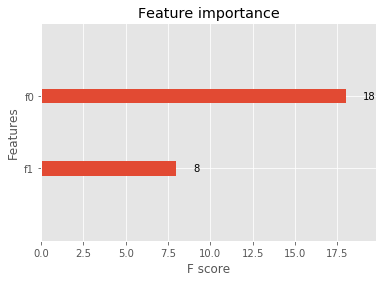

In [12]:
# 1.绘制重要性
xgb.plot_importance(bst)
# 2.绘制输出树
#xgb.plot_tree(bst, num_trees=2)
# 3.使用xgboost.to_graphviz()将目标树转换为graphviz
#xgb.to_graphviz(bst, num_trees=2)

# 7. Xgboost算法案例

## 分类案例

accuarcy: 96.67%


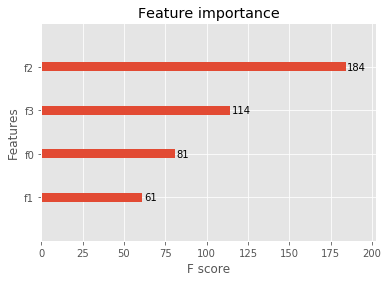

In [13]:
from sklearn.datasets import load_iris
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score   # 准确率
# 加载样本数据集
iris = load_iris()
X,y = iris.data,iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234565) # 数据集分割

# 算法参数
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 3,
    'gamma': 0.1,
    'max_depth': 6,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.75,
    'min_child_weight': 3,
    'silent': 0,
    'eta': 0.1,
    'seed': 1,
    'nthread': 4,
}

plst = params.items()

dtrain = xgb.DMatrix(X_train, y_train) # 生成数据集格式
num_rounds = 500
model = xgb.train(plst, dtrain, num_rounds) # xgboost模型训练

# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

# 计算准确率
accuracy = accuracy_score(y_test,y_pred)
print("accuarcy: %.2f%%" % (accuracy*100.0))

# 显示重要特征
plot_importance(model)
plt.show()

## 回归案例

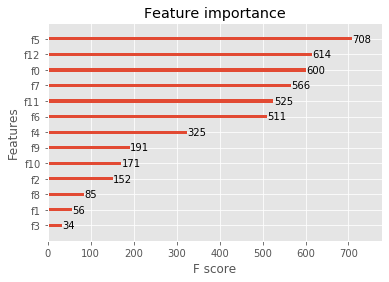

In [14]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

# 加载数据集
boston = load_boston()
X,y = boston.data,boston.target

# XGBoost训练过程
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'gamma': 0.1,
    'max_depth': 5,
    'lambda': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}

dtrain = xgb.DMatrix(X_train, y_train)
num_rounds = 300
plst = params.items()
model = xgb.train(plst, dtrain, num_rounds)

# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
ans = model.predict(dtest)

# 显示重要特征
plot_importance(model)
plt.show()

## XGBoost调参（结合sklearn网格搜索）
代码参考：https://www.jianshu.com/p/1100e333fcab

In [ ]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

iris = load_iris()
X,y = iris.data,iris.target
col = iris.target_names 
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=1)   # 分训练集和验证集
parameters = {
              'max_depth': [5, 10, 15, 20, 25],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'n_estimators': [500, 1000, 2000, 3000, 5000],
              'min_child_weight': [0, 2, 5, 10, 20],
              'max_delta_step': [0, 0.2, 0.6, 1, 2],
              'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
              'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
              'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
              'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
              'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1]

}

xlf = xgb.XGBClassifier(max_depth=10,
            learning_rate=0.01,
            n_estimators=2000,
            silent=True,
            objective='multi:softmax',
            num_class=3 ,          
            nthread=-1,
            gamma=0,
            min_child_weight=1,
            max_delta_step=0,
            subsample=0.85,
            colsample_bytree=0.7,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=0,
            missing=None)

gs = GridSearchCV(xlf, param_grid=parameters, scoring='accuracy', cv=3)
gs.fit(train_x, train_y)

print("Best score: %0.3f" % gs.best_score_)
print("Best parameters set: %s" % gs.best_params_ )

Best score: 0.933                                     
Best parameters set: {'max_depth': 5}

# 8. LightGBM算法

LightGBM也是像XGBoost一样，是一类集成算法，他跟XGBoost总体来说是一样的，算法本质上与Xgboost没有出入，只是在XGBoost的基础上进行了优化，因此就不对原理进行重复介绍，在这里我们来看看几种算法的差别：
   - 优化速度和内存使用
      - 降低了计算每个分割增益的成本。
      - 使用直方图减法进一步提高速度。
      - 减少内存使用。
      - 减少并行学习的计算成本。
   - 稀疏优化
      - 用离散的bin替换连续的值。如果#bins较小，则可以使用较小的数据类型（例如uint8_t）来存储训练数据 。 
      - 无需存储其他信息即可对特征数值进行预排序  。
   - 精度优化  
      - 使用叶子数为导向的决策树建立算法而不是树的深度导向。
      - 分类特征的编码方式的优化
      - 通信网络的优化
      - 并行学习的优化
      - GPU支持
      
LightGBM的优点：

　　1）更快的训练效率

　　2）低内存使用

　　3）更高的准确率

　　4）支持并行化学习

　　5）可以处理大规模数据

**1.速度对比：**                                        
![jupyter](./速度对比.png)                              
**2.准确率对比：**                                  
![jupyter](./准确率对比.png)                                                 
**3.内存使用量对比：**                               
![jupyter](./内存使用量.png)                                                       

**LightGBM参数说明：**
推荐文档1：https://lightgbm.apachecn.org/#/docs/6  
推荐文档2：https://lightgbm.readthedocs.io/en/latest/Parameters.html

**1.核心参数：**（括号内名称是别名）  
   - objective（objective，app ，application）：默认regression，用于设置损失函数
      - 回归问题：
         - L2损失：regression（regression_l2，l2，mean_squared_error，mse，l2_root，root_mean_squared_error，rmse）
         - L1损失：regression_l1（l1, mean_absolute_error, mae）
         - 其他损失：huber，fair，poisson，quantile，mape，gamma，tweedie
      - 二分类问题：二进制对数损失分类（或逻辑回归）：binary
      - 多类别分类：
         - softmax目标函数： multiclass（softmax）
         -  One-vs-All 目标函数：multiclassova（multiclass_ova，ova，ovr）
      - 交叉熵：
         - 用于交叉熵的目标函数（具有可选的线性权重）：cross_entropy（xentropy）
         - 交叉熵的替代参数化：cross_entropy_lambda（xentlambda） 
   - boosting ：默认gbdt，设置提升类型，选项有gbdt，rf，dart，goss，别名：boosting_type，boost
     - gbdt（gbrt）:传统的梯度提升决策树
     - rf（random_forest）：随机森林
     - dart：多个加性回归树的DROPOUT方法 Dropouts meet Multiple Additive Regression Trees，参见：https://arxiv.org/abs/1505.01866
     - goss：基于梯度的单边采样 Gradient-based One-Side Sampling   
   - data（train，train_data，train_data_file，data_filename）：用于训练的数据或数据file
   - valid （test，valid_data，valid_data_file，test_data，test_data_file，valid_filenames）：验证/测试数据的路径，LightGBM将输出这些数据的指标
   - num_iterations：默认=100，类型= INT
   - n_estimators：提升迭代次数，**LightGBM构造用于多类分类问题的树num_class * num_iterations**
   - learning_rate（shrinkage_rate，eta） ：收缩率，默认=0.1
   - num_leaves（num_leaf，max_leaves，max_leaf） ：默认=31，一棵树上的最大叶子数
   - tree_learner （tree，tree_type，tree_learner_type）：默认=serial，可选：serial，feature，data，voting
     - serial：单台机器的 tree learner
     - feature：特征并行的 tree learner
     - data：数据并行的 tree learner
     - voting：投票并行的 tree learner
   - num_threads（num_thread, nthread）：LightGBM 的线程数，为了更快的速度, 将此设置为真正的 CPU 内核数, 而不是线程的数量 (大多数 CPU 使用超线程来使每个 CPU 内核生成 2 个线程)，当你的数据集小的时候不要将它设置的过大 (比如, 当数据集有 10,000 行时不要使用 64 线程)，对于并行学习, 不应该使用全部的 CPU 内核, 因为这会导致网络性能不佳。  
   - device（device_type）：默认cpu，为树学习选择设备, 你可以使用 GPU 来获得更快的学习速度，可选cpu, gpu。
   - seed （random_seed，random_state）：与其他种子相比，该种子具有较低的优先级，这意味着如果您明确设置其他种子，它将被覆盖。
   
**2.用于控制模型学习过程的参数：**
   - max_depth：限制树模型的最大深度. 这可以在 #data 小的情况下防止过拟合. 树仍然可以通过 leaf-wise 生长。
   - min_data_in_leaf： 默认=20，一个叶子上数据的最小数量. 可以用来处理过拟合。
   - min_sum_hessian_in_leaf（min_sum_hessian_per_leaf, min_sum_hessian, min_hessian）：默认=1e-3，一个叶子上的最小 hessian 和. 类似于 min_data_in_leaf, 可以用来处理过拟合.
   - feature_fraction：default=1.0，如果 feature_fraction 小于 1.0, LightGBM 将会在每次迭代中随机选择部分特征. 例如, 如果设置为 0.8, 将会在每棵树训练之前选择 80% 的特征，可以用来加速训练，可以用来处理过拟合。
   - feature_fraction_seed：默认=2，feature_fraction 的随机数种子。
   - bagging_fraction（sub_row, subsample）：默认=1，不进行重采样的情况下随机选择部分数据
   - bagging_freq（subsample_freq）：bagging 的频率, 0 意味着禁用 bagging. k 意味着每 k 次迭代执行bagging
   - bagging_seed（bagging_fraction_seed） ：默认=3，bagging 随机数种子。
   - early_stopping_round（early_stopping_rounds, early_stopping）：默认=0，如果一个验证集的度量在 early_stopping_round 循环中没有提升, 将停止训练
   - lambda_l1（reg_alpha）：L1正则化系数
   - lambda_l2（reg_lambda）：L2正则化系数
   - min_split_gain（min_gain_to_split）：执行切分的最小增益，默认=0.
   - cat_smooth：默认=10，用于分类特征，可以降低噪声在分类特征中的影响, 尤其是对数据很少的类别
   
**3.度量参数：**
   - metric：default={l2 for regression}, {binary_logloss for binary classification}, {ndcg for lambdarank}, type=multi-enum, options=l1, l2, ndcg, auc, binary_logloss, binary_error …
      - l1, absolute loss, alias=mean_absolute_error, mae
      - l2, square loss, alias=mean_squared_error, mse
      - l2_root, root square loss, alias=root_mean_squared_error, rmse
      - quantile, Quantile regression
      - huber, Huber loss
      - fair, Fair loss
      - poisson, Poisson regression
      -   ndcg, NDCG
      -   map, MAP
      -   auc, AUC
      -   binary_logloss, log loss
      -   binary_error, 样本: 0 的正确分类, 1 错误分类
      -   multi_logloss, mulit-class 损失日志分类
      -   multi_error, error rate for mulit-class 出错率分类
      -   xentropy, cross-entropy (与可选的线性权重), alias=cross_entropy
      -   xentlambda, “intensity-weighted” 交叉熵, alias=cross_entropy_lambda
      -   kldiv, Kullback-Leibler divergence, alias=kullback_leibler
      -   支持多指标, 使用 , 分隔
   - train_metric（training_metric, is_training_metric）：默认=False，如果你需要输出训练的度量结果则设置 true  
   
**4.GPU 参数：**
   - gpu_device_id：default为-1, 这个default意味着选定平台上的设备。         

**LightGBM与网格搜索结合调参：**                                                             
参考代码：https://blog.csdn.net/u012735708/article/details/83749703

In [19]:
import lightgbm as lgb
from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
 
canceData=load_breast_cancer()
X=canceData.data
y=canceData.target
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0,test_size=0.2)
 
### 数据转换
print('数据转换')
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train,free_raw_data=False)
 
### 设置初始参数--不含交叉验证参数
print('设置参数')
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': 'auc',
          'nthread':4,
          'learning_rate':0.1
          }
 
### 交叉验证(调参)
print('交叉验证')
max_auc = float('0')
best_params = {}
 
# 准确率
print("调参1：提高准确率")
for num_leaves in range(5,100,5):
    for max_depth in range(3,8,1):
        params['num_leaves'] = num_leaves
        params['max_depth'] = max_depth
 
        cv_results = lgb.cv(
                            params,
                            lgb_train,
                            seed=1,
                            nfold=5,
                            metrics=['auc'],
                            early_stopping_rounds=10,
                            verbose_eval=True
                            )
            
        mean_auc = pd.Series(cv_results['auc-mean']).max()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
            
        if mean_auc >= max_auc:
            max_auc = mean_auc
            best_params['num_leaves'] = num_leaves
            best_params['max_depth'] = max_depth
if 'num_leaves' and 'max_depth' in best_params.keys():          
    params['num_leaves'] = best_params['num_leaves']
    params['max_depth'] = best_params['max_depth']
 
# 过拟合
print("调参2：降低过拟合")
for max_bin in range(5,256,10):
    for min_data_in_leaf in range(1,102,10):
            params['max_bin'] = max_bin
            params['min_data_in_leaf'] = min_data_in_leaf
            
            cv_results = lgb.cv(
                                params,
                                lgb_train,
                                seed=1,
                                nfold=5,
                                metrics=['auc'],
                                early_stopping_rounds=10,
                                verbose_eval=True
                                )
                    
            mean_auc = pd.Series(cv_results['auc-mean']).max()
            boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
 
            if mean_auc >= max_auc:
                max_auc = mean_auc
                best_params['max_bin']= max_bin
                best_params['min_data_in_leaf'] = min_data_in_leaf
if 'max_bin' and 'min_data_in_leaf' in best_params.keys():
    params['min_data_in_leaf'] = best_params['min_data_in_leaf']
    params['max_bin'] = best_params['max_bin']
 
print("调参3：降低过拟合")
for feature_fraction in [0.6,0.7,0.8,0.9,1.0]:
    for bagging_fraction in [0.6,0.7,0.8,0.9,1.0]:
        for bagging_freq in range(0,50,5):
            params['feature_fraction'] = feature_fraction
            params['bagging_fraction'] = bagging_fraction
            params['bagging_freq'] = bagging_freq
            
            cv_results = lgb.cv(
                                params,
                                lgb_train,
                                seed=1,
                                nfold=5,
                                metrics=['auc'],
                                early_stopping_rounds=10,
                                verbose_eval=True
                                )
                    
            mean_auc = pd.Series(cv_results['auc-mean']).max()
            boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
 
            if mean_auc >= max_auc:
                max_auc=mean_auc
                best_params['feature_fraction'] = feature_fraction
                best_params['bagging_fraction'] = bagging_fraction
                best_params['bagging_freq'] = bagging_freq
 
if 'feature_fraction' and 'bagging_fraction' and 'bagging_freq' in best_params.keys():
    params['feature_fraction'] = best_params['feature_fraction']
    params['bagging_fraction'] = best_params['bagging_fraction']
    params['bagging_freq'] = best_params['bagging_freq']
 
 
print("调参4：降低过拟合")
for lambda_l1 in [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]:
    for lambda_l2 in [1e-5,1e-3,1e-1,0.0,0.1,0.4,0.6,0.7,0.9,1.0]:
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
        cv_results = lgb.cv(
                            params,
                            lgb_train,
                            seed=1,
                            nfold=5,
                            metrics=['auc'],
                            early_stopping_rounds=10,
                            verbose_eval=True
                            )
                
        mean_auc = pd.Series(cv_results['auc-mean']).max()
        boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
 
        if mean_auc >= max_auc:
            max_auc=mean_auc
            best_params['lambda_l1'] = lambda_l1
            best_params['lambda_l2'] = lambda_l2
if 'lambda_l1' and 'lambda_l2' in best_params.keys():
    params['lambda_l1'] = best_params['lambda_l1']
    params['lambda_l2'] = best_params['lambda_l2']
 
print("调参5：降低过拟合2")
for min_split_gain in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    params['min_split_gain'] = min_split_gain
    
    cv_results = lgb.cv(
                        params,
                        lgb_train,
                        seed=1,
                        nfold=5,
                        metrics=['auc'],
                        early_stopping_rounds=10,
                        verbose_eval=True
                        )
            
    mean_auc = pd.Series(cv_results['auc-mean']).max()
    boost_rounds = pd.Series(cv_results['auc-mean']).idxmax()
 
    if mean_auc >= max_auc:
        max_auc=mean_auc
        
        best_params['min_split_gain'] = min_split_gain
if 'min_split_gain' in best_params.keys():
    params['min_split_gain'] = best_params['min_split_gain']
 
print(best_params)

{'bagging_fraction': 0.7,                                          
 'bagging_freq': 30,                           
 'feature_fraction': 0.8,                                 
 'lambda_l1': 0.1,                            
 'lambda_l2': 0.0,                                 
 'max_bin': 255,                       
 'max_depth': 4,                            
 'min_data_in_leaf': 81,                                
 'min_split_gain': 0.1,                               
 'num_leaves': 10}                            

# 9. 结语

本章中，我们主要探讨了基于Boosting方式的集成方法，其中主要讲解了基于错误率驱动的Adaboost，基于残差改进的提升树，基于梯度提升的GBDT，基于泰勒二阶近似的Xgboost以及LightGBM。在实际的比赛或者工程中，基于Boosting的集成学习方式是非常有效且应用非常广泛的。更多的学习有待读者更深入阅读文献，包括原作者论文以及论文复现等。下一章我们即将探讨另一种集成学习方式：Stacking集成学习方式，这种集成方式虽然没有Boosting应用广泛，但是在比赛中或许能让你的模型更加出众。

**本章作业：**                              
本章在最后介绍LightGBM的时候并没有详细介绍它的原理以及它与XGBoost的不一样的地方，希望读者好好看看别的文章分享，总结LigntGBM与XGBoost的不同，然后使用一个具体的案例体现两者的不同。